# Supplemental Submission - CoNaLa Mined Data

This workbook includes a sample of the work done to import and discuss the CoNaLa mined data set before it was removed from analysis due to performance considerations, and the inability to conduct lengthy analysis on its poor-quality data as a result of time constraint.

This is not an exhaustive account of the work done with the mined data since it has been used in modelling attempts, but for the sake of readability and cohesiveness of the submission, these have not been included. This would have constituted a large amount of redundancy in the approach.

The cells below are not edited for appropriate report submission and are included to give a sample of the assessment of the mined data. Please keep in mind that the reporting and code below are incomplete.

***

- I assume the data set which I've modified from the *mined* data of the competition is adequately described by the "probability" it includes (discussed in more detail below). If the model which generates these probabilities is heavily flawed, then the result will be a poorly performing model as it is based on this data. Additionally, any bias which is included in the method for generating a probability score will feed forward into my own model, as this score was used to interpret the quality of the data.

Recall from the [**CoNaLa Section**](#CoNaLa) above, the CoNaLa Competition also provided a set of mined data. This is comprised of data crawled from Stack Overflow with about 600,000 examples. However, these examples have not been been curated by annotators like the other sets. This data therefore needs to be more scrutinized.  

These are included in the same direct download as the others, again available here: [CoNaLa Corpus v1.1 (.zip file, 52.1 MB)](http://www.phontron.com/download/conala-corpus-v1.1.zip).

This data is provided in the format of a .jsonl file, so slightly different than above. I peeked at the data, and show a preview included below:

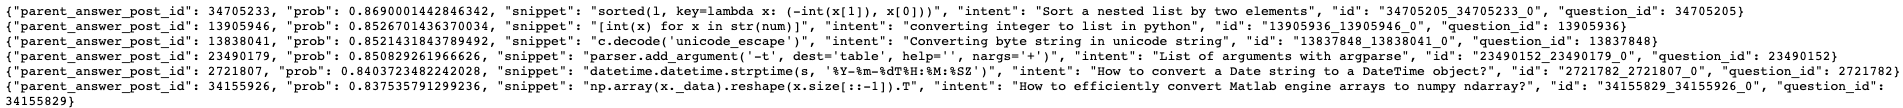

Notably, this data is not contained in a list object, but includes multiple json objects in sequence.

In [ ]:
# CoNala Mined Data

# This file is different in format from the other CoNaLa Competition Data, 
# and contains multiple json objects. We need to handle it differently.

# First instantiate an empty list, this will be used hold all of the dictionary objects as a list
# of dictionaries.
conala_mined_data_list = []

# Open file, loop through the json objects in the file, appending the list each time. 
with open('data/conala-corpus/conala-mined.jsonl') as f:
    for jsonObj in tqdm(f):
        code_dic = json.loads(jsonObj)
        conala_mined_data_list.append(code_dic)

In [ ]:
# Peek at the list created.
conala_mined_data_list[-5:]

This data is now in the same list of json objects format that the train and test data above were. It can be converted into a pandas DataFrame similarly.

Below I look briefly into the shape and contents of this DataFrame.

In [ ]:
# Convert list of json objets for mined data into pandas DataFrame
conala_mined_df = pd.DataFrame(conala_mined_data_list)

# Peek at the DataFrame for the mined CoNaLa data.
display(conala_mined_df.head())

# Check shape of the DataFrame
conala_mined_df.shape

Note that the index is not random, the records are sorted such that the probabilities decrease along the list. That is, the lower the rank of the index, the higher the probability score. To look more at the distribution of the probabilities included, the `pd.describe()` function is useful. 

In [ ]:
# Looking at the DataFrame's statistics for numerical columns.
# Drop the columns for which statistics are not meaningful.
conala_mined_df.drop(["parent_answer_post_id", "question_id"], axis=1).describe()

The `parent_answer_post_id` and `question_id` columns are not too meaninful since the numbers stored in these columns are nominal, so these were dropped in the above.

The statistics we see for the `prob` column is quite informative here. Of note, the mean probability is very low, at 6.4%, and even the 75th percentile is much lower than expected at 7.5%. This means there are far fewer records here where the code snippet is confidently associated with an intent than I was hoping for. This problem is discussed in the study which produced this mined code: 

> existing heuristic methods (e.g., pairing the title of a post with the code in the accepted answer) are limited both in their coverage and the
correctness of the NL-code pairs obtained.

To get a better intuition for how this `prob` score describes the association of the given `intent` and `snippet` I manually sampled the data and reviewed it.

Firstly, for records with any `prob` value. 

In [ ]:
# First sample from the whole DataFrame.
# Run cell multiple times to see random samples.
conala_mined_df.sample(10)

Now, for records with `prob` values greater than `0.5`. 

In [ ]:
# Sample from the DataFrame, among records with prob > 0.5.
# Run cell multiple times to see random samples.
conala_mined_df[conala_mined_df['prob']>0.5].sample(10)

The intent of each row is commonly cut off in the cell output as the string is too long. In order to rectify this and view the entire contents, the below can be run.

In [ ]:
# Use this cell to view full contents of intent and snippet strings for specific 
# records in the sample, by its index.
ind = 143 # index 143 just as an example
print(conala_mined_df.loc[ind,'intent'])
print(conala_mined_df.loc[ind,'snippet'])

Visually exploring these code snippets would be easier if the snippets and intent could be viewed among multiple other records. In the below cell, I created a method of exporting rows to a csv file for visual and manual exploration. I used the below cell for many values of `ind`, and therefore many records in order to view and compare the snippets and intent contained in the `mined_df`. This was an important exercise so to get familiar with how well the `prob` score indicates the relation of these other two fields.

In [ ]:
# Store this record result in helper csv file to aid manually viewing individual
# records as a random sample. 
# Run for each value of `ind` to be appended to a csv file for exploration.
with open('prob_explore.csv', mode='a+') as f:
    pd.DataFrame(conala_mined_df.loc[ind]).T.to_csv(f, mode='a+', header=False)

After conducting multiple samples of the data, and with inspection of the columns `intent` and `snippet`, I've concluded that the the code snippets with low probability scores in the mined data are so poorly related with the intent they have been mined with that they are not valuable for training a model. I will remove a large number of the records based on the prob score they have. 

#### Proposed `prob` Cutoff
[[Back To TOC]](#Table-of-Contents)

Through the exploration and sampling above, I've learned that many records which have a probability of 50% or greater are quite reasonably associated with their code snippet. 

In the cell below we can determine how many records meet this threshold.

In [ ]:
# Can use this function to determine how many records have a probability greater than `prob_thresh`
prob_thresh = 0.5
len(conala_mined_df[conala_mined_df["prob"]>prob_thresh])

In [ ]:
# Use the mined_df with only the records with probability greater than 50%. 
conala_mined_df = conala_mined_df[conala_mined_df['prob']>prob_thresh]

In [ ]:
# &&&&&& Pickle the mined df. 
pickled_conala_mined_df = open('pickled_conala_mined_df', 'ab+') 
# source, destination 
pickle.dump(conala_mined_df, pickled_conala_mined_df)                      
pickled_conala_mined_df.close() 

In [ ]:
conala_mined_df

## Combining Data
[[Back To TOC]](#Table-of-Contents)

We have have three DataFrames now. Let's look at their shapes and column names. We should compare them to make sure they are consistent, or create a plan for making them consistent.

In [ ]:
# Summarize the shapes
print("Shape of CoNaLa train df:", conala_train_df.shape)
print("Shape of CoNaLa test df:", conala_test_df.shape)
print("Shape of CoNaLa mined df:", conala_mined_df.shape)

print("\nColumns of CoNaLa train df:\n", conala_train_df.columns)
print("\nColumns of CoNaLa test df:\n", conala_test_df.columns)
print("\nColumns of CoNaLa mined df:\n", conala_mined_df.columns)

The `conala_mined_df` has three columns that are the same as the other two, and is missing one column. 

Same columns:
- `question_id`
- `snippet`
- `intent`

Missing Column:
- `rewritten_intent`

The `question id` appears to be used as an index. I should be able to do the same, but will have to check with the mined data that the numbers don't overlap as these need to be unique.

The `snippet` column is where the snippets of code are contained. It's very likely that this column shouldn't be modified before being vectorized since this is the data that I'm trying to interpret and I do not want to introduce bias. When I conduct vectorizing on this shortly, there will be some decisions to be made about how to break up the data.

The `intent` column contains plain english questions submitted by developers to [Stack Overflow](#stackoverflow.com), in order to achieve certain tasks. This contains information about **desired intent**. Unfortunately most of these are written as questions and so the intent is not structured as preferred. 

The `rewritten_intent` column is a colum which has been viewed by the CoNaLa team to create a more plain-english description about the code in question. This will be extremely helpful since this represents some preliminary cleaning which has already been done for me. Unfortunately this doesn't exist for the `conala_mined_df` so I'll have to determine how to either create it, or handle the disparity.

This is a good time to export the data to a readable format for me to review visually.

In [ ]:
# Export to csv for readability.
conala_train_df.to_csv(r'conala_train_df.csv')
conala_test_df.to_csv(r'conala_test_df.csv')
# This is a big dataset so we should reduce it 
conala_mined_df.to_csv(r'conala_mined_df.csv')

#### Vectorizing `conala_mined_df` with Bag of Words
[[Back To TOC]](#Table-of-Contents)

We should have less confidence in the `intent` field contained in `conala_mined_df`, since this field is coming from a procedurally collected dataset, and has not been manually cleaned like that of the trained data. Because of this I'm proposing to use the bag of words we have fit to the train dataset in order to transform the mined dataset here. This will (hopefully) have the effect of identifying the words that should be considered as signficant to determining intent, as indicated by the fit on the training data set.

In [ ]:
# Check for nan
conala_mined_df.isna().sum()

In [ ]:
# Transform with the bag of words from the train df
conala_mined_bag_SM = conala_train_bagofwords.transform(conala_mined_df["intent"])
conala_mined_bag_SM

The number of stored elements from the mined df is a bit low. This may not be a good way of interpreting the mined code. There's some things we can try/consider: 

- graph min_df, and look at vocab size as WELL as elements contained. as WELL as vocab:records, elements:records. 

- only some of the mined records have high probability anyways, maybe we can filter out low probabilities and try again.
- maybe we filter out the rows that have no words in the bag of words which will cut down the data anways
- maybe both.

In [ ]:
# Create a DataFrame (more workable) from the Sparse Matrix 
conala_mined_bag_df = pd.DataFrame(columns=conala_train_bagofwords.get_feature_names(),
                                   data=conala_mined_bag_SM.toarray())

In [ ]:
conala_mined_bag_df.sum().sort_values(ascending=False)

#### Comparing Vectorized `conala_mined_df` and `conala_trained_df`
[[Back To TOC]](#Table-of-Contents)

In [ ]:
conala_train_bag_df.sum().index==conala_mined_bag_df.sum().index

In [ ]:
conala_train_bag_df.sum().values
conala_mined_bag_df.sum().values

In [ ]:
# Create a df for comparison of word frequency in bag of words
bag_df = pd.DataFrame(data={"train_freq":conala_train_bag_df.sum().values, "mined_freq":conala_mined_bag_df.sum().values},
             index=conala_train_bag_df.sum().index)

In [ ]:
# Inspecting the most common terms of the bag of words.
display(bag_df.sort_values(by="train_freq", ascending=False))
display(bag_df.sort_values(by="mined_freq", ascending=False))

In [ ]:
train_bag_sorted = bag_df.sort_values(by="train_freq", ascending=False)

In [ ]:
# Plot term frequency, mined compared with train
plt.figure(figsize=(8,80))
plt.barh(train_bag_sorted.index,train_bag_sorted["train_freq"], fill=False, edgecolor='b')
plt.barh(train_bag_sorted.index,train_bag_sorted["mined_freq"], fill=False, edgecolor='r')
plt.autoscale(enable=True, axis='y', tight=True)
plt.show()

The terms are actually quite comparable. Enough so that I'm comfortable proceeding with this for preliminary modelling.

One point in particular is worth noting. The term "python" is far more represented in the mined data. This indicates to me that the term is so frequently used that it is not actually helpful in identifying intent. This is not a surprising result since the CoNaLa competition was designed with Python code specifically being analyzed. **I'm going to drop this row** since it simply does not give valuable information seeing as the code should all be written in python anyways.

#### Combining DataFrames
[[Back To TOC]](#Table-of-Contents)

In [ ]:
print(conala_train_bag_df.shape)
print(conala_mined_bag_df.shape)
print(conala_train_bag_df.shape[0]+conala_mined_bag_df.shape[0])

In [ ]:
combined_bag_df = pd.concat([conala_train_bag_df, conala_mined_bag_df], ignore_index=True)
combined_bag_df

The first 2379 rows are from the train data, and the last 3385 are from the mined data.

In [ ]:
# Dropping the `python` column
combined_bag_df.drop(columns="python", index=1, inplace=True)

In [ ]:
from varname import nameof
# &&&&&& Pickling both dfs. 
pickle_list = [conala_train_bag_df, conala_mined_bag_df, combined_bag_df]

for df in pickle_list:
    file = open(f'pickled_{nameof(df)}', 'ab+') 
    pickle.dump(df, file)                      
    file.close()